In [72]:
# %%
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

In [100]:
# Define training parameters
training_start_date = '1970-02-02'
training_end_date = '2024-06-01'
prediction_start_date = '2024-06-02'
prediction_end_date = '2024-10-25'
num_epochs = 30
n_future = 1
batch_size = 16
hidden_size = 64
output_size = 1

In [101]:
df_full = pd.read_csv('yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])

cols = list(df_full)[1:2]  # Adjust based on your DataFrame structure
df_for_training = df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)][cols].astype(float)

In [102]:
# Convert 'Date' column to index for time series analysis
df_for_training.set_index(df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)]['Date'], inplace=True)

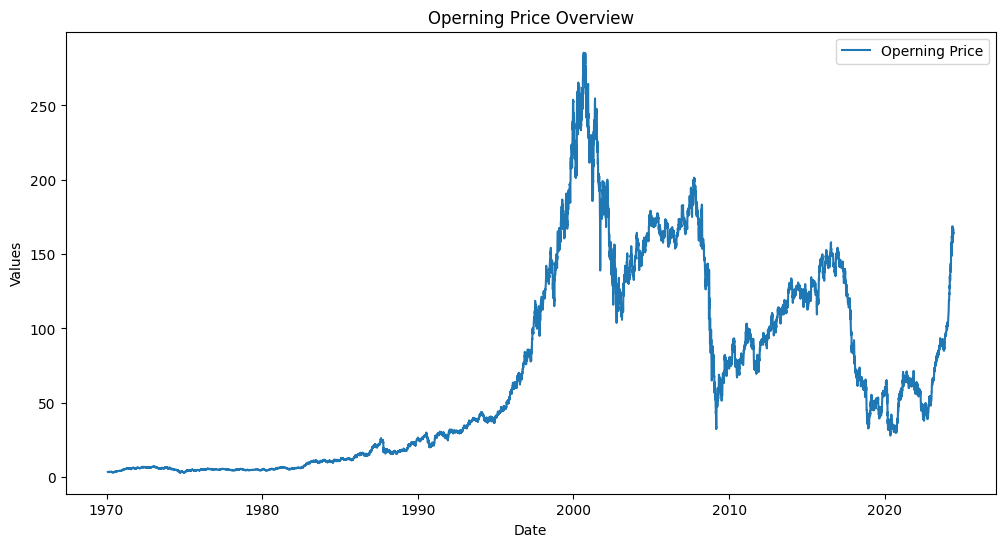

In [103]:
# Plot the time series data for a visual check
plt.figure(figsize=(12, 6))
plt.plot(df_for_training, label="Operning Price")
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Operning Price Overview')
plt.legend()
plt.show()


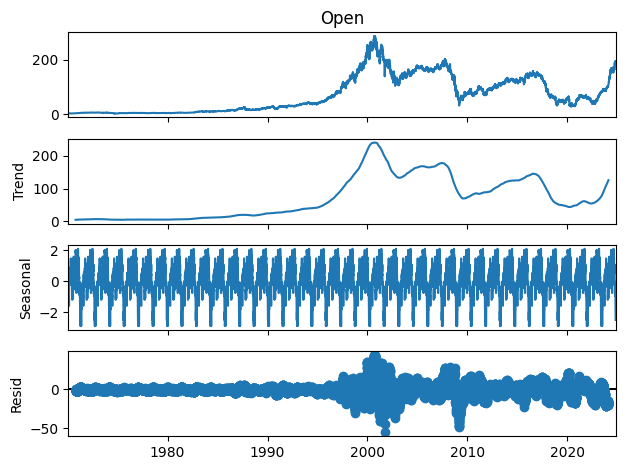

In [104]:

from statsmodels.tsa.seasonal import seasonal_decompose

df_full = pd.read_csv('yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full.sort_values('Date', ascending=True, inplace=True)
df_full.set_index('Date', inplace=True)

decomposition = seasonal_decompose(df_full['Open'], model='additive', period=365 )  # Adjust period based on seasonality (e.g., 12 for monthly)
decomposition.plot()
plt.show()
# Load and inspect data
df_full = pd.read_csv('yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])


In [105]:
# %%
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use only the last output
        x = self.fc(x)
        return x


In [106]:
# Prepare the training data
def prepare_data(df, n_past):
    cols = list(df)[1:6]  # Adjust based on your DataFrame structure
    df_for_training = df[(df['Date'] >= training_start_date) & (df['Date'] <= training_end_date)][cols].astype(float)

    # Normalize training data 
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)

    # Prepare data for LSTM
    trainX, trainY = [], []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Predicting the first column

    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY, scaler, df_for_training, cols

In [107]:
# Define function to train model with a given window size
def train_model(n_past, num_epochs=5):
    trainX, trainY, scaler, df_for_training, cols = prepare_data(df_full, n_past)

    # Convert numpy arrays to torch tensors
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float().view(-1, 1)

    # Split the data into training and validation sets
    train_size = int(len(trainX) * 0.8)
    trainX_tensor, valX_tensor = trainX[:train_size], trainX[train_size:]
    trainY_tensor, valY_tensor = trainY[:train_size], trainY[train_size:]

    # Create data loaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(trainX_tensor, trainY_tensor)
    val_dataset = torch.utils.data.TensorDataset(valX_tensor, valY_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, criterion, and optimizer
    model = LSTMModel(input_size=trainX.shape[2], hidden_size=hidden_size, output_size=output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(valX_tensor)
        val_outputs = val_outputs.numpy()
        valY_tensor = valY_tensor.numpy()

    # Calculate metrics
    mse = mean_squared_error(valY_tensor, val_outputs)
    mae = mean_absolute_error(valY_tensor, val_outputs)
    r2 = r2_score(valY_tensor, val_outputs)

    # Make predictions
    make_predictions(n_past, model, scaler, df_for_training, cols)

    return mse, mae, r2

In [108]:
# Define function to make predictions and visualize results
def make_predictions(n_past, model, scaler, df_for_training, cols):
    # Filter dataset by prediction date range
    df_prediction_temp = df_full[(df_full['Date'] >= prediction_start_date) & (df_full['Date'] <= prediction_end_date)]
    
    # Normalize prediction data
    df_prediction_scaled = scaler.transform(df_prediction_temp[cols].astype(float))

    predictionX = []
    for i in range(n_past, len(df_prediction_scaled) - n_future + 1):
        predictionX.append(df_prediction_scaled[i - n_past:i, :])

    predictionX = np.array(predictionX)
    predictionX_tensor = torch.from_numpy(predictionX).float()

    model.eval()
    with torch.no_grad():
        predictions = model(predictionX_tensor)

    # Inverse transform the predictions to original scale
    predictions_inverse = scaler.inverse_transform(
        np.concatenate([predictions.numpy(), np.zeros((predictions.shape[0], df_for_training.shape[1] - 1))], axis=1)
    )[:, 0]

    # Also inverse-transform actual values for comparison
    actual_values = df_prediction_temp['Open'].iloc[n_past:].values

    # Plotting Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], actual_values, label='Actual Open Prices', color='blue')
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], predictions_inverse, label='Predicted Open Prices', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.title(f'Actual vs Predicted Open Prices (Window Size: {n_past})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [109]:
# Test different window sizes
window_sizes = [5, 10, 20, 60, 100]

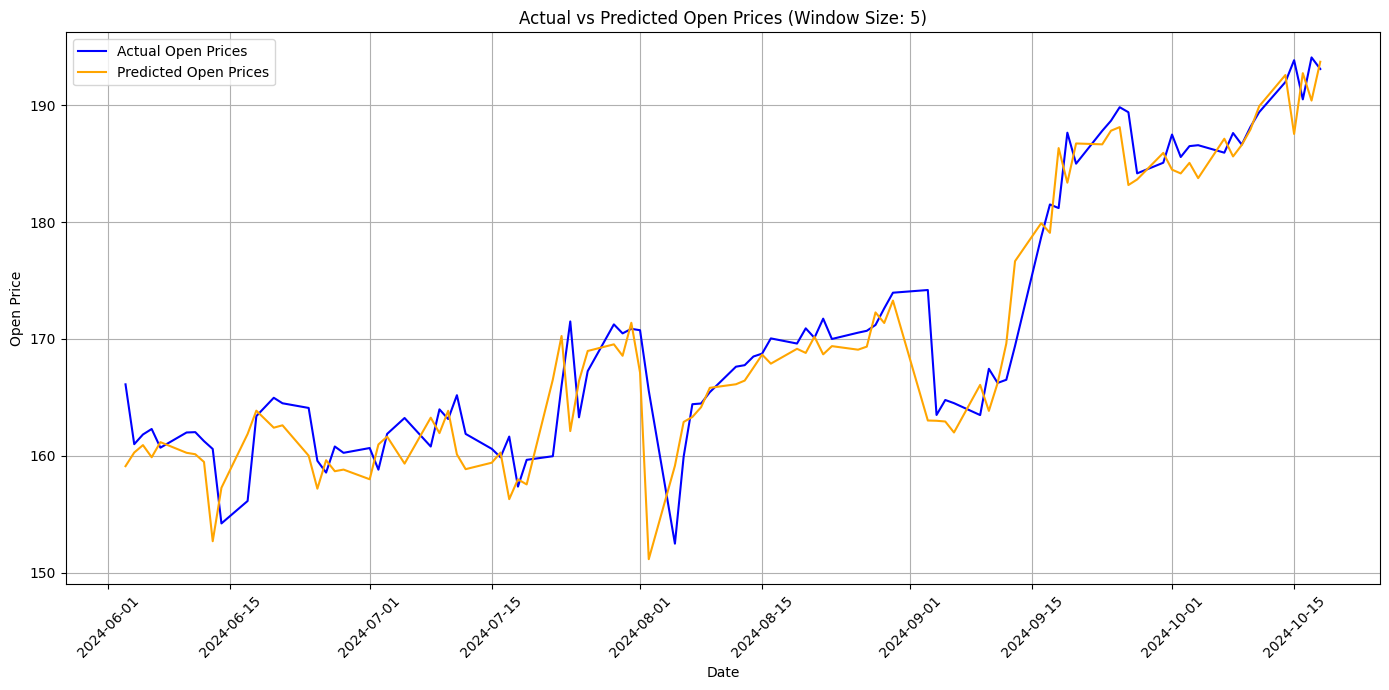

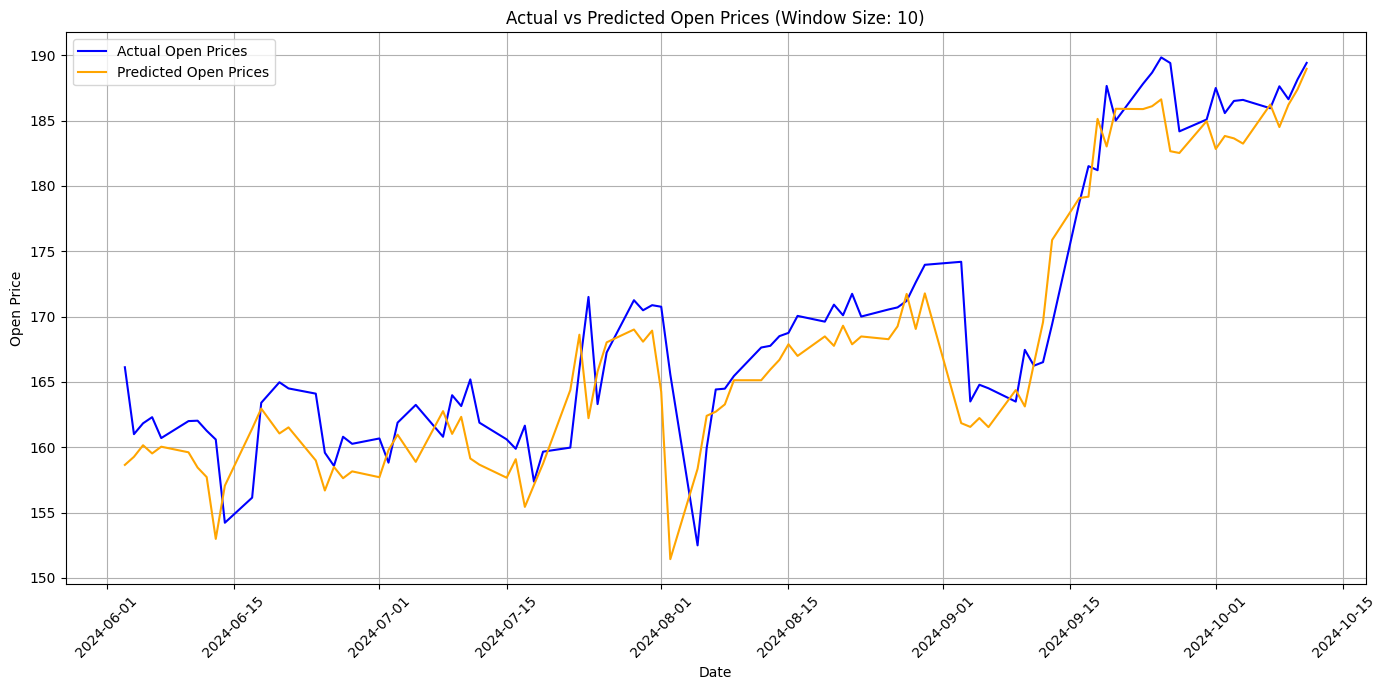

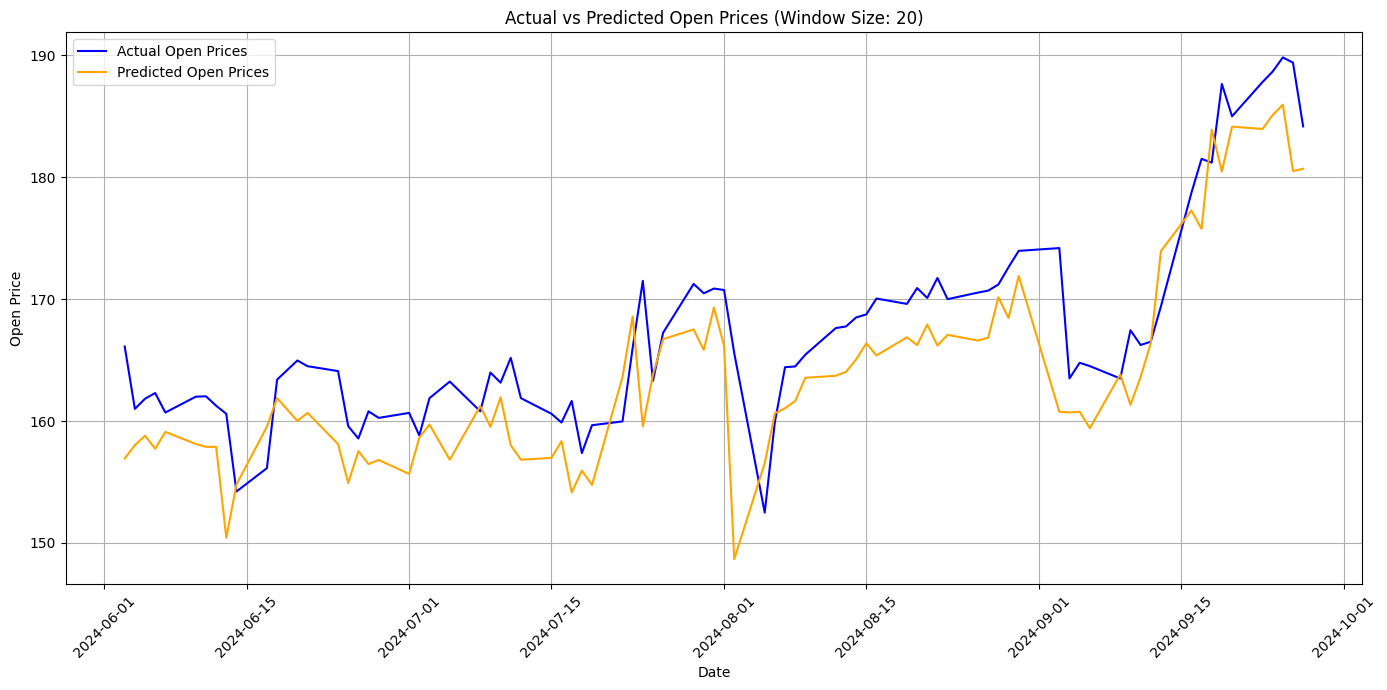

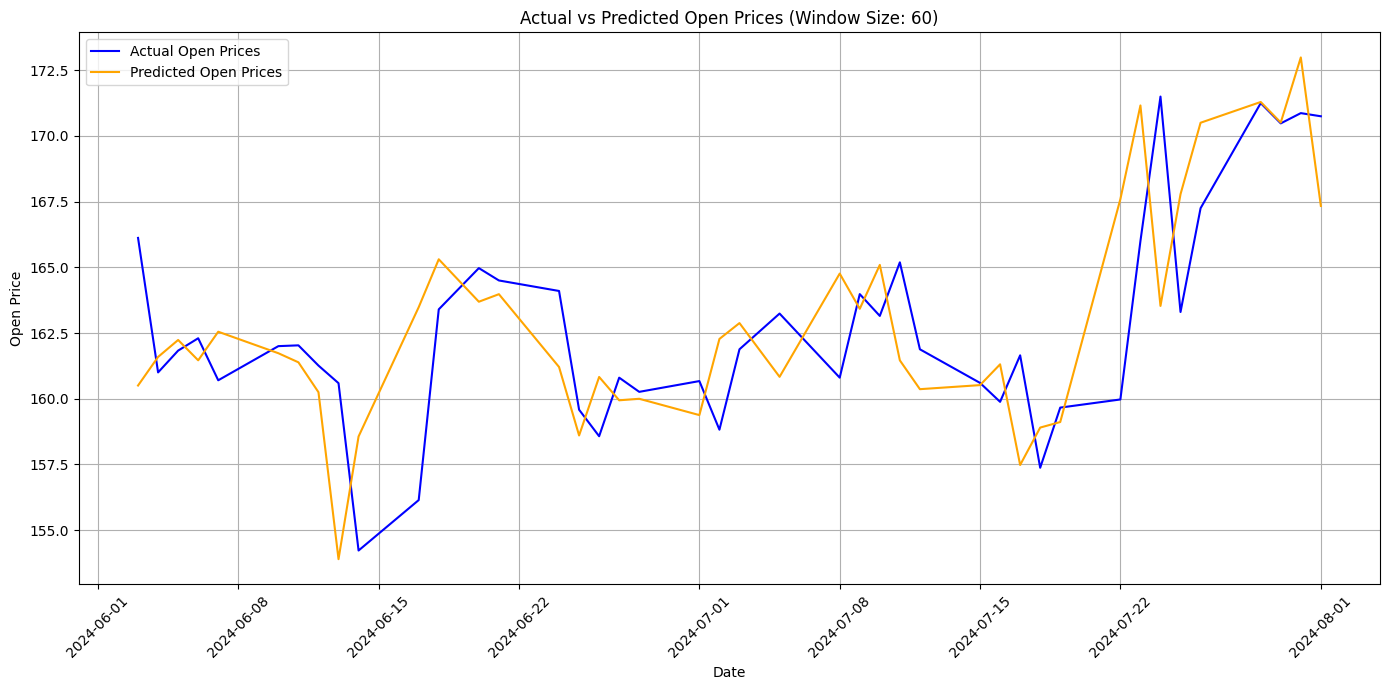

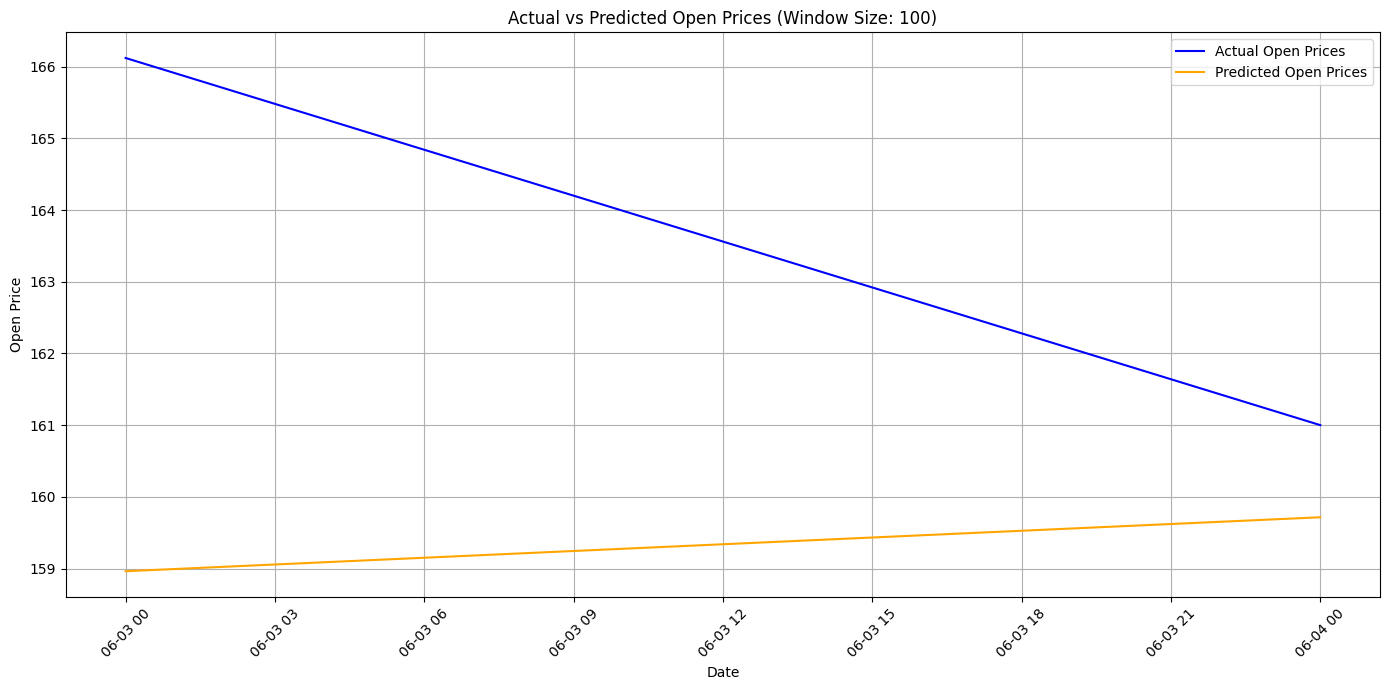

In [ ]:
# Example window sizes
results = []

for window_size in window_sizes:
    mse, mae, r2 = train_model(n_past=window_size, num_epochs=num_epochs)
    results.append({
        'Window Size': window_size,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

   Window Size       MSE       MAE         R²
0            5  0.000592  0.024229  -2.395201
1           10  0.000046  0.006567   0.735144
2           20  0.002445  0.049398 -13.008815
3           60  0.000030  0.005219   0.826662
4          100  0.001554  0.039390  -7.889966


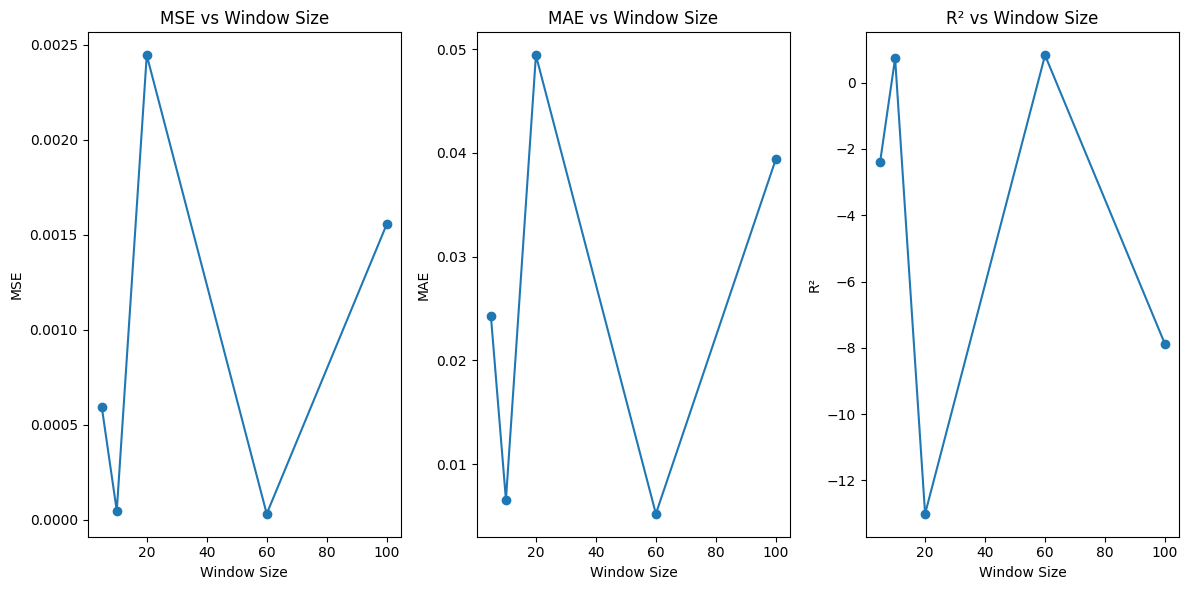

In [111]:
# Create a DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results_df['Window Size'], results_df['MSE'], marker='o')
plt.title('MSE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(results_df['Window Size'], results_df['MAE'], marker='o')
plt.title('MAE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.plot(results_df['Window Size'], results_df['R²'], marker='o')
plt.title('R² vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('R²')

plt.tight_layout()
plt.show()
